In [3]:
%matplotlib inline

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from tensorflow import keras
from tensorflow.keras import layers, datasets, models, losses, backend
from sklearn.manifold import TSNE

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [6]:
# Process MNIST
mnist_train = (x_train > 0).reshape(60000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test = (x_test > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)

# Load MNIST-M
mnistm = pkl.load(open('mnistm_data.pkl', 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']

# Compute pixel mean for normalizing data
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))

In [7]:
origin_1 = np.ones([mnist_train.shape[0],1])
origin_2 = np.zeros([mnistm_train.shape[0],1])
origins = np.vstack([origin_1, origin_2])
train = np.vstack([mnist_train, mnistm_train])
dummy = np.zeros([mnistm_train.shape[0],1]) - 1
labels = np.vstack([y_train.reshape([-1,1]), dummy])

# Normalizaing
train = (train-pixel_mean) / 255.

In [8]:
print("train: {}".format(train.shape))
print("label: {}".format(labels.shape))
print("origin: {}".format(origins.shape))

train: (102000, 28, 28, 3)
label: (102000, 1)
origin: (102000, 1)


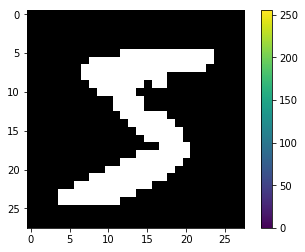

In [6]:
plt.figure()
plt.imshow(mnist_train[0])
plt.colorbar()

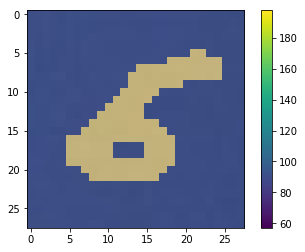

In [7]:
plt.imshow(mnistm_train[0])
plt.colorbar()

W1105 21:39:01.835825 139785461974784 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


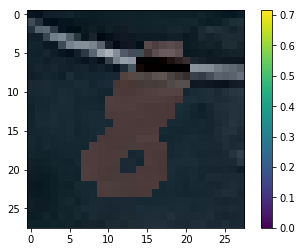

In [8]:
plt.imshow(train[90001])
plt.colorbar()

In [11]:
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)
    
def masking(input_pair):
    # classification
    mask = tf.dtypes.cast(backend.reshape(input_pair[:,-1], shape=[-1]), tf.bool)
    rslt = tf.boolean_mask(input_pair[:,0:-1], mask)
    return rslt

# layer = layers.Lambda(masking)
# print(layer([tf.random.uniform([4,2]),
#              [True,False,False,True]]))

In [89]:
class MNISTModel(object):
    def __init__(self):
        self.model = self._build_model()
        # losses & optimizer
        self.domain_loss = losses.BinaryCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam()
        
    def _build_model(self):
        # inputs
        image_input = keras.Input(shape=(28, 28, 3), name='img_input')
        label_input = keras.Input(shape=(1, ), name='lbl_input')
        origin_input = keras.Input(shape=(1, ), name='org_input')
        
        # feature model
        fm = layers.Conv2D(32, (5, 5),
                           activation='relu',
                           input_shape=(28, 28, 3),
                           padding='same')(image_input)
        fm = layers.MaxPooling2D((2, 2))(fm)
        fm = layers.Conv2D(64, (5, 5),
                           activation='relu',
                           padding='same')(fm)
        fm = layers.MaxPooling2D((2, 2))(fm)
        fm = layers.Flatten()(fm)
        
        # class model
        cm = layers.Concatenate()([fm, origin_input])
        cm = layers.Lambda(masking)(cm)
        cm = layers.Dense(100, activation='relu')(cm)
        cm = layers.Dense(100, activation='relu')(cm)
        cm = layers.Dense(10)(cm)
        cm = layers.Softmax(name='cm')(cm)
        
        # domain model
        dm = GradReverse()(fm)
        dm = layers.Dense(100, activation='relu')(dm)
        dm = layers.Dense(1)(dm)
        dm = layers.Softmax(name='dm')(dm)
        
        model = keras.Model(inputs=[image_input, origin_input],
                            outputs=[cm, dm])
        self.cm = keras.Model(inputs=[image_input, origin_input],
                              outputs=[cm])
        
        # custom loss
        model.add_loss(self.dann_loss(label_input, cm, origin_input))
        model.add_loss(tf.keras.losses.binary_crossentropy(tf.reshape(label_input, [-1,1]), dm, True))
        
        model.summary()
        return model
    
    def dann_loss(self, y_true, y_pred, origins):            
        y_true = tf.reshape(y_true,[-1, 1, 10])
        y_pred = tf.reshape(y_pred,[-1, 1, 10])

        ytm = tf.boolean_mask(y_true, origins, axis=0)
        ypm = tf.boolean_mask(y_pred, origins, axis=0)

        return tf.keras.losses.sparse_categorical_crossentropy(ytm, ypm)


    def train_model(self, images, labels, origins):
        self.model.compile(loss=None, optimizer=self.optimizer)
        self.model.fit([images, labels, origins],
                       batch_size=32,
                       epochs=1)

In [90]:
mnm = MNISTModel()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 28, 28, 32)   2432        img_input[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 14, 14, 32)   0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 14, 14, 64)   51264       max_pooling2d_48[0][0]           
___________________________________________________________________________________________

In [81]:
train[0].shape

(28, 28, 3)

In [92]:
mnm.cm.predict([train, origins])

ValueError: could not broadcast input array from shape (0,10) into shape (32,10)

In [76]:
mnm.train_model(train, np.reshape(labels,[-1, 1]), origins)

W1114 20:08:55.059319 140014429443840 training_utils.py:1152] Output cm missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to cm.
W1114 20:08:55.062849 140014429443840 training_utils.py:1152] Output dm missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dm.


InvalidArgumentError: You must feed a value for placeholder tensor 'lbl_input_22' with dtype float and shape [?,1,1]
	 [[{{node lbl_input_22}}]] [Op:__inference_keras_scratch_graph_16057]

In [126]:
class DannCategoricalLoss(keras.losses.Loss):
    def __init__(self, origins,
                 from_logits=False,
                 axis=-1,
                name='dann_categorical_loss'):
        super(DannCategoricalLoss, self).__init__(reduction=reduction,
                                                  name=name)
        self.origins = origins
        self.from_logits = from_logits
        self.axis = axis
        
    def masking(input_pair):
        # classification
        mask = tf.dtypes.cast(backend.reshape(input_pair[:,-1], shape=[-1]), tf.bool)
        rslt = tf.boolean_mask(input_pair[:,0:-1], mask)
        return rslt
    
    def call(self, y_true, y_pred):
        mask = tf.dtypes.cast(self.origins, tf.bool)
        
        y_t_m = masking(y_true, origins)
        y_p_m = masking(y_pred, origins)
        return tf.keras.losses.sparse_categorical_crossentropy(
                    y_true,
                    y_pred,
                    from_logits=self.from_logits,
                    axis=self.axis
                )
    
    def dann_loss(y_true, y_pred):
        
        ytm = tf.boolean_mask(y_true, mask)
        ypm = tf.boolean_mask(y_pred, mask)

        return tf.keras.losses.sparse_categorical_crossentropy(ytm, ypm)

In [146]:
origins.reshape(-1).shape

(102000,)

In [12]:
class MNISTModel(object):
    """Simple MNIST domain adaptation model."""
    def __init__(self):
        # models
        self.feature_model = self._feature_model()
        self.class_model = self._class_model()
        self.domain_model = self._domain_model()
        # losses & optimizer
        self.class_loss = losses.SparseCategoricalCrossentropy()
        self.domain_loss = losses.BinaryCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam()
    
    def _feature_model(self):
        model = tf.keras.models.Sequential()
        model.add(layers.Conv2D(32, (5, 5),
                                activation='relu',
                                input_shape=(28, 28, 3),
                                padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        
        model.add(layers.Conv2D(64, (5, 5),
                                activation='relu',
                                padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
        return model
    
    def _class_model(self):
        model = tf.keras.models.Sequential()
        model.add(self.feature_model)
        model.add(layers.Dense(100,
                               input_shape=(7 * 7 * 64,),
                               activation='relu'))
        model.add(layers.Dense(100,
                               activation='relu'))
        model.add(layers.Dense(10))
        model.add(layers.Softmax())
        model.summary()
        return model
    
    def _domain_model(self):
        model = tf.keras.models.Sequential()
        model.add(self.feature_model)
        model.add(GradReverse()) # reverse the gradient
        model.add(layers.Dense(100,
                               input_shape=(7 * 7 * 48,),
                               activation='relu'))
        model.add(layers.Dense(1))
        model.add(layers.Softmax())
        model.summary()
        return model
    
    @tf.function
    def train_dann(self, images, labels, origins):
        # classification
        mask = tf.dtypes.cast(backend.reshape(origins, shape=[-1]), tf.bool)
        x_able = tf.boolean_mask(images, mask)
        y_able = tf.boolean_mask(labels, mask)
        with tf.GradientTape() as tape:
            pred_class = self.class_model(x_able)
            loss_class = self.class_loss(y_able, pred_class)
#             gradients_class = tape.gradient(loss_class, self.class_model.trainable_variables)
#             self.optimizer.apply_gradients(zip(gradients_class, self.class_model.trainable_variables))

        # domain prediction
        with tf.GradientTape() as tape:
            pred_domain = self.domain_model(images)
            loss_domain = self.domain_loss(origins, pred_domain)
#             gradients_domain = tape.gradient(loss_domain, self.domain_model.trainable_variables)
#             self.optimizer.apply_gradients(zip(gradients_domain, self.domain_model.trainable_variables))
        
        total_loss = loss_class + loss_domain
        tvars = dann.class_model.trainable_variables + dann.domain_model.trainable_variables
        tf.keras.optimizers.Adam().minimize(total_loss, [tvars])

    def train_asis(self, images, labels):
        self.class_model.compile(self.optimizer, self.class_loss)
        self.class_model.fit(images, labels, epochs=1, batch_size=64)

In [13]:
dann = MNISTModel()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 3136)              53696     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               313700    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
_________________________________________________________________
softmax_1 (Softmax)          (None, 10)                0         
Total params: 378,506
Trainable params: 378,506
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)              

In [18]:
dann.class_model.trainable_variables

[<tf.Variable 'conv2d_2/kernel:0' shape=(5, 5, 3, 32) dtype=float32, numpy=
 array([[[[ 0.04273044,  0.03967943,  0.06380701, ...,  0.00700906,
            0.06594543, -0.00825683],
          [ 0.01697833,  0.05492947, -0.00273457, ..., -0.04849068,
            0.00904884, -0.05157634],
          [-0.02514752,  0.06928247,  0.07893243, ..., -0.02198617,
            0.04415752, -0.07723675]],
 
         [[ 0.06719677,  0.06639546,  0.05421785, ...,  0.04741561,
            0.03840895,  0.01205764],
          [-0.02141536, -0.06090537, -0.05532675, ...,  0.00653185,
            0.04771496,  0.02218267],
          [ 0.07167935, -0.07105279,  0.04610175, ...,  0.04347795,
           -0.07361033, -0.00749856]],
 
         [[ 0.0106892 ,  0.05216792,  0.073549  , ...,  0.00824751,
           -0.01585638,  0.07396127],
          [ 0.05080789, -0.02441129, -0.044643  , ..., -0.05079776,
            0.07260688,  0.03345164],
          [ 0.00820092,  0.07991523, -0.06838953, ...,  0.05006792,
  

In [26]:
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices(
    (train.astype(np.float32), labels, origins)).shuffle(102000).batch(batch_size)

In [44]:
test = (mnist_test-pixel_mean) / 255.
test2 = (mnistm_train-pixel_mean) / 255.
dann.class_model.compile(dann.optimizer, dann.class_loss)

In [38]:
tv = list(set(dann.class_model.trainable_variables + dann.domain_model.trainable_variables))


False

In [41]:
def train_dann(images, labels, origins):
    # classification
    mask = tf.dtypes.cast(backend.reshape(origins, shape=[-1]), tf.bool)
    x_able = tf.boolean_mask(images, mask)
    y_able = tf.boolean_mask(labels, mask)
    
    # gradient
    with tf.GradientTape() as tape:
        pred_class = dann.class_model(x_able)
        loss_class = dann.class_loss(y_able, pred_class)

        pred_domain = dann.domain_model(images)
        loss_domain = dann.domain_loss(origins, pred_domain)

        total_loss = loss_class + loss_domain
        tvars = list(set(dann.class_model.trainable_variables + dann.domain_model.trainable_variables))
        
    grads = tape.gradient(total_loss, tvars)
    dann.optimizer.apply_gradients(zip(grads, tvars))

In [59]:
for _ in range(3):
    for train_b, label_b, origin_b in train_ds:
        train_dann(train_b, label_b, origin_b)
    dann.class_model.evaluate(test, y_test)    

10000/10000 [==============================] - 4s 368us/sample - loss: 0.0582


In [ ]:
# train dann
for _ in range(3):
    for train_b, label_b, origin_b in train_ds:
        dann.train_dann(train_b, label_b, origin_b)
    dann.class_model.evaluate(test, y_test)

In [48]:
dann.class_model(test2[:1].astype(np.float32)).numpy()

array([[0.02907381, 0.018162  , 0.00421676, 0.00785536, 0.02176128,
        0.6584875 , 0.14419425, 0.00690657, 0.08157871, 0.02776381]],
      dtype=float32)

W1115 00:53:56.194568 140691998480128 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


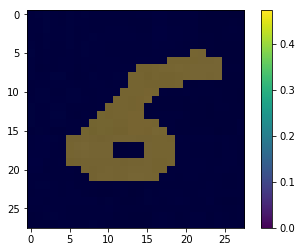

In [49]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(test2[0])
plt.colorbar()

In [50]:
nn = MNISTModel()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 3136)              53696     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               313700    
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
_________________________________________________________________
softmax_3 (Softmax)          (None, 10)                0         
Total params: 378,506
Trainable params: 378,506
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
Layer (type)              

In [51]:
mask = tf.dtypes.cast(backend.reshape(origins, shape=[-1]), tf.bool)
x_able = tf.boolean_mask(train, mask)
y_able = tf.boolean_mask(labels, mask)

In [60]:
# train nn
for _ in range(3):
    history = nn.train_asis(x_able, y_able)
    nn.class_model.evaluate(test, y_test)

10000/10000 [==============================] - 4s 355us/sample - loss: 0.0456


In [61]:
# Create a mixed dataset for TSNE visualization
num_test = 500
combined_test_imgs = np.vstack([mnist_test[:num_test], mnistm_test[:num_test]])
combined_test_imgs = (combined_test_imgs - pixel_mean) / 255.
combined_test_imgs.shape
y_test2 = y_test.reshape(-1,1)
combined_test_labels = np.vstack([y_test2[:num_test], y_test2[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),
        np.tile([0., 1.], [num_test, 1])])

In [62]:
dann_emb = dann.feature_model(combined_test_imgs.astype('float32'))
tsne_d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dann_tsne = tsne_d.fit_transform(dann_emb)

In [63]:
nn_emb = nn.feature_model(combined_test_imgs.astype('float32'))
tsne_n = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
nn_tsne = tsne_n.fit_transform(nn_emb)

In [64]:
n = combined_test_labels.reshape(-1).astype('str')
z = dann_tsne[:,0]
y = dann_tsne[:,1]
z2 = nn_tsne[:,0]
y2 = nn_tsne[:,1]

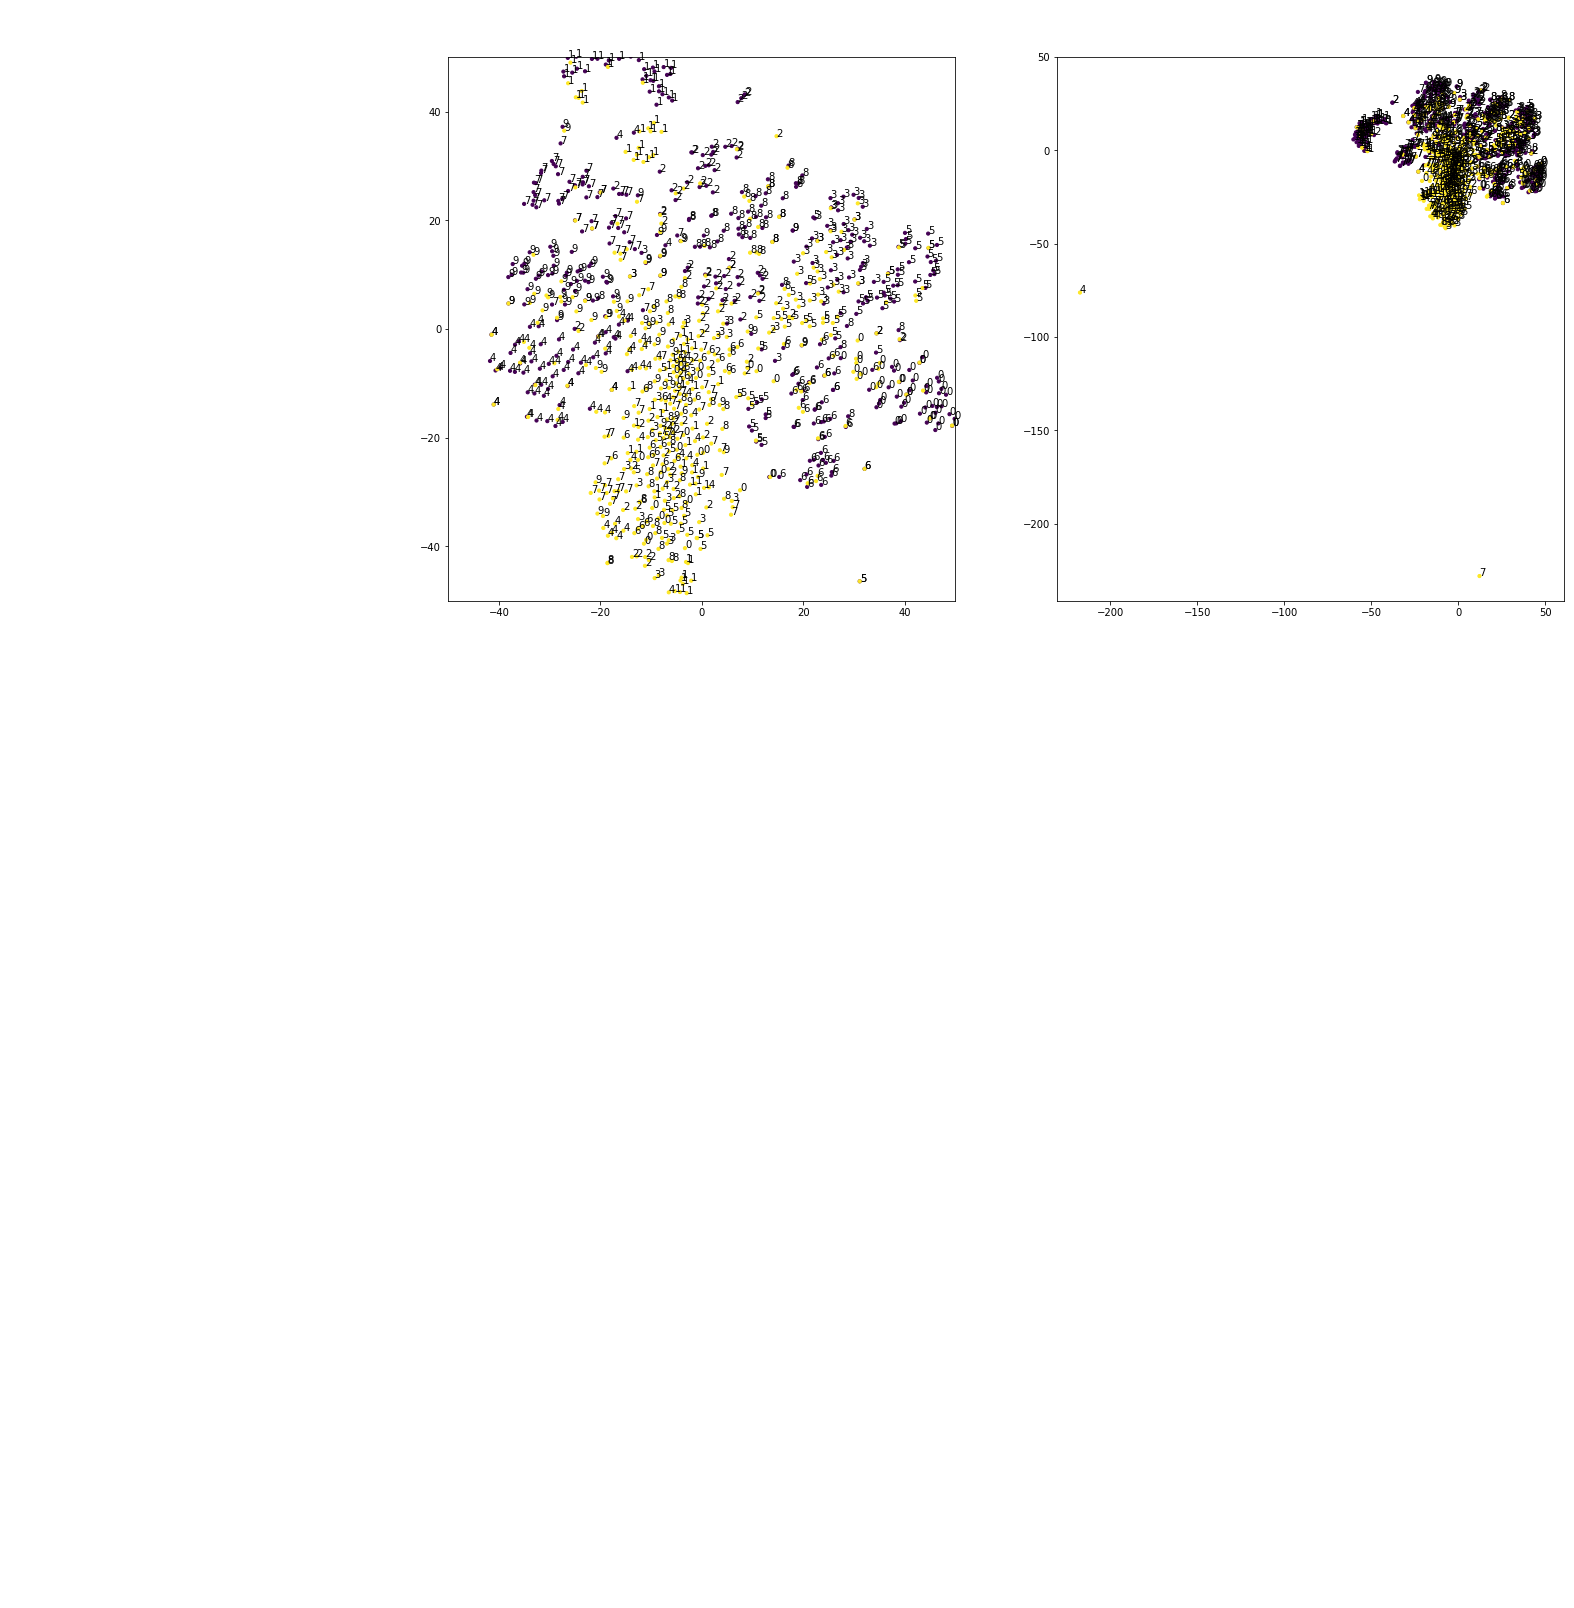

In [65]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(z, y, c=combined_test_domain.argmax(1), s=10)
for i, txt in enumerate(n):
    ax1.annotate(txt, (z[i], y[i]))
ax1.set_xlim(-50,50)
ax1.set_ylim(-50,50)

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(z2, y2, c=combined_test_domain.argmax(1), s=10)
for i, txt in enumerate(n):
    ax2.annotate(txt, (z2[i], y2[i]))